# **YOLOv8 Model**

In [1]:
! pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.0/613.0 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 8.2 MB/s eta 0:00:00


In [2]:
from ultralytics import YOLO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import yaml
import shutil

%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
train_imgs_dir="/Datasets/train_images"
train_labels="/Datasets/train_solution_bounding_boxes.csv"

test_imgs_dir="/Datasets/test_images"

In [4]:
imgs_list=list(sorted(os.listdir(train_imgs_dir)))
idxs=list(range(len(imgs_list)))
np.random.shuffle(idxs)

train_idx=idxs[:int(0.8*len(idxs))]
val_idx=idxs[int(0.8*len(idxs)):]

In [6]:
root_dir="/data"
labels_dir="/data/labels"
images_dir="/data/images"

In [7]:
df=pd.read_csv(train_labels)

width=676
height=380

df["class"]=0
df.rename(columns={'image':'img_name'}, inplace=True)

df["x_centre"]=(df["xmin"]+df["xmax"])/2
df["y_centre"]=(df["ymin"]+df["ymax"])/2
df["width"]=(df["xmax"]-df["xmin"])
df["height"]=(df["ymax"]-df["ymin"])

#normalizing bounding box coordinates
df["x_centre"]=df["x_centre"]/width
df["y_centre"]=df["y_centre"]/height
df["width"]=df["width"]/width
df["height"]=df["height"]/height

df_yolo=df[["img_name","class","x_centre","y_centre","width","height"]]
df_yolo.head()

,img_name,class,x_centre,y_centre,width,height
0,vid_4_1000.jpg,0,0.450434,0.539817,0.068741,0.095238
1,vid_4_10000.jpg,0,0.100217,0.557191,0.155572,0.129987
2,vid_4_10040.jpg,0,0.444645,0.543678,0.181621,0.157014
3,vid_4_10020.jpg,0,0.833213,0.531451,0.197540,0.155727
4,vid_4_10060.jpg,0,0.110347,0.559122,0.171491,0.136422


In [8]:
for idx,img_name in enumerate(imgs_list):
    subset="train"
    if idx in val_idx:
        subset="val"
        
    if np.isin(img_name,df_yolo["img_name"]):
        columns=["class","x_centre","y_centre","width","height"]
        img_bbox=df_yolo[df_yolo["img_name"]==img_name][columns].values
        
        label_file_path=os.path.join(labels_dir,subset,img_name[:-4]+".txt")
        with open(label_file_path,"w+") as f:
            for row in img_bbox:
                text=" ".join(row.astype(str))
                f.write(text)
                f.write("\n")
                
    old_image_path=os.path.join(train_imgs_dir,img_name)
    new_image_path=os.path.join(images_dir,subset,img_name)
    shutil.copy(old_image_path,new_image_path)

In [9]:
yolo_format=dict(path="/data",
                 train="/data/images/train",
                 val="/data/images/val",
                 nc=1,
                 names={0:"car"})
             
with open('/results/yolo.yaml', 'w') as outfile:
    yaml.dump(yolo_format, outfile, default_flow_style=False)

In [11]:
model=YOLO('yolov8m.pt')
model.train(data="/results/yolo.yaml",epochs=50,patience=5,batch=8,
                    lr0=0.0005,imgsz=640)

100%|██████████| 49.7M/49.7M [00:00<00:00, 189MB/s]
Ultralytics YOLOv8.0.154 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/kaggle/working/yolo.yaml, epochs=50, patience=5, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, form

In [12]:
path_best_weights="/results/runs/detect/train/weights/best.pt"
model = YOLO(path_best_weights) 

metrics = model.val() 

Ultralytics YOLOv8.0.154 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients
val: Scanning /kaggle/working/data/labels/val.cache... 74 images, 127 backgrounds, 0 corrupt: 100%|██████████| 201/201 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  3.21it/s]
                   all        201        120      0.989      0.967      0.993      0.647
Speed: 3.4ms preprocess, 8.5ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/val


In [13]:
print(f"Mean Average Precision @.5:.95 : {metrics.box.map}")    
print(f"Mean Average Precision @ .50   : {metrics.box.map50}") 
print(f"Mean Average Precision @ .70   : {metrics.box.map75}")

Mean Average Precision @.5:.95 : 0.6474751560326882
Mean Average Precision @ .50   : 0.9928191769286261
Mean Average Precision @ .70   : 0.7946627399790244


In [14]:
results=model.predict(source=test_imgs_dir,conf=0.50,iou=0.75)


image 1/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25100.jpg: 384x640 (no detections), 76.2ms
image 2/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25120.jpg: 384x640 (no detections), 11.0ms
image 3/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25140.jpg: 384x640 (no detections), 11.0ms
image 4/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25160.jpg: 384x640 (no detections), 11.0ms
image 5/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25180.jpg: 384x640 (no detections), 10.9ms
image 6/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25200.jpg: 384x640 (no detections), 11.0ms
image 7/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25220.jpg: 384x640 (no detections), 11.0ms
image 8/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25240.jpg: 384x640 (no detections), 11.0ms
image 9/175 /kaggle/input/car-object-detection/data/testing_images/vid_

In [17]:
test_img_list=[]
for result in results:
    if len(result.boxes.xyxy):
        name=result.path.split("/")[-1].split(".")[0]
        boxes=result.boxes.xyxy.cpu().numpy()
        scores=result.boxes.conf.cpu().numpy()
        
        test_img_list.append(name)
        
        label_file_path=os.path.join(prediction_dir,name+".txt")
        with open(label_file_path,"w+") as f:
            for score,box in zip(scores,boxes):
                text=f"{score:0.4f} "+" ".join(box.astype(str))
                f.write(text)
                f.write("\n")

In [18]:
def show_bbox(img,boxes,scores,axis,color=(0,255,0)):
    boxes=boxes.astype(int)
    scores=scores
    img=img.copy()
    for i,box in enumerate(boxes):
        score=f"{scores[i]:.4f}"
        cv2.rectangle(img,(box[0],box[1]),(box[2],box[3]),color,2)
        y=box[1]-10 if box[1]-10>10 else box[1]+10
        cv2.putText(img,score,(box[0],y),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,2)
    
    axis.imshow(img)
    axis.axis("off")

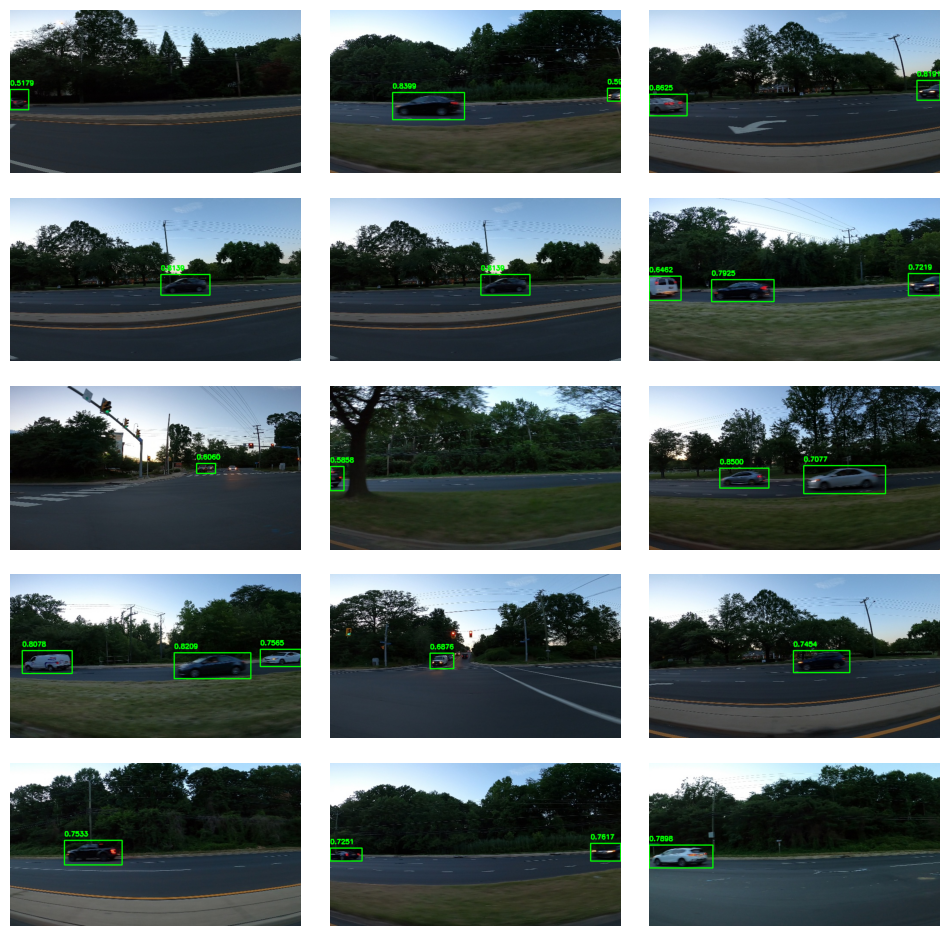

In [19]:
fig,axes=plt.subplots(5,3,figsize=(12,12))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
ax=axes.flatten()

imgs_name=np.random.choice(test_img_list,15)

for i,img_name in enumerate(imgs_name):
    img_file_path=os.path.join(test_imgs_dir,img_name+".jpg")
    img=cv2.imread(img_file_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    label_file_path=os.path.join(prediction_dir,img_name+".txt")
    label=pd.read_csv(label_file_path,sep=" ",header=None).values
    scores=label[:,0]
    boxes=label[:,1:]
    show_bbox(img,boxes,scores,axis=ax[i])
    
plt.savefig("1.png")

# **VGG16 Model**

In [1]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import imutils
import os


2024-03-06 11:52:09.874682: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-06 11:52:09.874732: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-06 11:52:09.876165: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
IMAGES_PATH = os.path.sep.join(["/Datasets/training_images"])
ANNOTS_PATH = os.path.sep.join(["/Datasets/train_solution_bounding_boxes (1).csv"])


In [3]:
BASE_OUTPUT = "output"
os.makedirs(BASE_OUTPUT, exist_ok=True)
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector.h5"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_FILENAMES = os.path.sep.join([BASE_OUTPUT, "test_images.txt"])

In [4]:
rows = open(ANNOTS_PATH).read().strip().split("\n")

data = []
targets = []
filenames = []


In [5]:
rows[:5]

['image,xmin,ymin,xmax,ymax',
 'vid_4_1000.jpg,281.2590449,187.0350708,327.7279305,223.225547',
 'vid_4_10000.jpg,15.16353111,187.0350708,120.3299566,236.4301802',
 'vid_4_10040.jpg,239.1924747,176.7648005,361.9681621,236.4301802',
 'vid_4_10020.jpg,496.4833575,172.3632561,630.0202605,231.5395753']

In [6]:
for row in rows[1:]:
    row = row.split(",")
    (filename, startX, startY, endX, endY) = row
    imagePath = os.path.join(IMAGES_PATH, filename)
    image = cv2.imread(imagePath)
    (h, w) = image.shape[:2]
    startX = float(startX) / w
    startY = float(startY) / h
    endX = float(endX) / w
    endY = float(endY) / h
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    data.append(image)
    targets.append((startX, startY, endX, endY))
    filenames.append(filename)


In [7]:
data[:2]

[array([[[127., 210., 254.],
         [127., 210., 254.],
         [128., 211., 255.],
         ...,
         [ 98., 181., 251.],
         [103., 184., 249.],
         [100., 183., 251.]],
 
        [[129., 212., 254.],
         [128., 211., 255.],
         [129., 212., 255.],
         ...,
         [104., 182., 255.],
         [104., 181., 251.],
         [104., 182., 255.]],
 
        [[129., 212., 254.],
         [129., 212., 254.],
         [129., 212., 254.],
         ...,
         [102., 184., 255.],
         [103., 182., 255.],
         [101., 184., 254.]],
 
        ...,
 
        [[ 29.,  53.,  81.],
         [ 27.,  50.,  81.],
         [ 27.,  50.,  81.],
         ...,
         [ 22.,  44.,  68.],
         [ 21.,  43.,  67.],
         [ 22.,  44.,  68.]],
 
        [[ 28.,  52.,  80.],
         [ 28.,  52.,  80.],
         [ 29.,  53.,  81.],
         ...,
         [ 21.,  43.,  67.],
         [ 21.,  43.,  67.],
         [ 21.,  43.,  67.]],
 
        [[ 28.,  51.,  82.],
 

In [8]:
targets[:5]

[(0.416063675887574, 0.4921975547368421, 0.4848046309171598, 0.58743565),
 (0.022431259038461538,
  0.4921975547368421,
  0.17800289437869823,
  0.6221846847368421),
 (0.35383502174556214,
  0.46517052763157896,
  0.5354558610946745,
  0.6221846847368421),
 (0.7344428365384615,
  0.4535875160526316,
  0.9319826338757395,
  0.6093146718421053),
 (0.02460202605029586,
  0.49091055342105266,
  0.19609261937869824,
  0.6273326897368421)]

In [9]:
filenames[:5]

['vid_4_1000.jpg',
 'vid_4_10000.jpg',
 'vid_4_10040.jpg',
 'vid_4_10020.jpg',
 'vid_4_10060.jpg']

In [10]:
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")

# Split the data into training and testing sets along with filenames
split = train_test_split(data, targets, filenames, test_size=0.10, random_state=42)
(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]

with open(TEST_FILENAMES, "w") as f:
    f.write("\n".join(testFilenames))


In [11]:
trainImages[:2]

array([[[[0.41960785, 0.6862745 , 0.9254902 ],
         [0.42352942, 0.6901961 , 0.9372549 ],
         [0.42745098, 0.69411767, 0.9411765 ],
         ...,
         [0.4117647 , 0.6509804 , 0.90588236],
         [0.4117647 , 0.6509804 , 0.90588236],
         [0.4117647 , 0.6509804 , 0.90588236]],

        [[0.42352942, 0.6901961 , 0.9372549 ],
         [0.43529412, 0.7019608 , 0.9490196 ],
         [0.43137255, 0.69803923, 0.94509804],
         ...,
         [0.41568628, 0.654902  , 0.9098039 ],
         [0.41568628, 0.654902  , 0.9098039 ],
         [0.41568628, 0.654902  , 0.9098039 ]],

        [[0.43137255, 0.69803923, 0.94509804],
         [0.43529412, 0.7019608 , 0.9490196 ],
         [0.4392157 , 0.7058824 , 0.9529412 ],
         ...,
         [0.41568628, 0.654902  , 0.9098039 ],
         [0.41568628, 0.654902  , 0.9098039 ],
         [0.41568628, 0.654902  , 0.9098039 ]],

        ...,

        [[0.10588235, 0.09803922, 0.10196079],
         [0.1764706 , 0.14901961, 0.10980392]

In [12]:
trainTargets[:5]

array([[6.1505067e-01, 4.7417954e-01, 7.8219968e-01, 5.8743566e-01],
       [8.9507961e-01, 4.6388352e-01, 1.0000000e+00, 5.7456565e-01],
       [7.2358898e-04, 5.1793760e-01, 9.4066568e-02, 5.9901863e-01],
       [3.8494936e-01, 5.1793760e-01, 5.6005788e-01, 6.2347168e-01],
       [5.3095412e-01, 4.9469721e-01, 6.3947558e-01, 5.8148479e-01]],
      dtype=float32)

In [13]:
trainFilenames[:5]

['vid_4_6440.jpg',
 'vid_4_2080.jpg',
 'vid_4_2060.jpg',
 'vid_4_23000.jpg',
 'vid_4_8680.jpg']

In [14]:
testFilenames[:4]

['vid_4_17540.jpg', 'vid_4_6360.jpg', 'vid_4_12300.jpg', 'vid_4_21240.jpg']

In [15]:
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

vgg.trainable = False

flatten = vgg.output
flatten = Flatten()(flatten)

# Add fully connected layers for bounding box regression
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)

model = Model(inputs=vgg.input, outputs=bboxHead)


In [16]:
INIT_LR = 1e-4
NUM_EPOCHS = 25
BATCH_SIZE = 32

In [17]:
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="mean_squared_error", optimizer=opt, metrics=["accuracy"])

print(model.summary())


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,936,548 (68.42 MB)

 Trainable params: 3,221,860 (12.29 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [18]:
H = model.fit(
    trainImages, trainTargets,
    validation_data=(testImages, testTargets),
    shuffle=True,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1
)


Epoch 1/25
 1/16 ━━━━━━━━━━━━━━━━━━━━ 8:47 35s/step - accuracy: 0.0000e+00 - loss: 0.0759

I0000 00:00:1709725975.048415    1340 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1709725975.067806    1340 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3478 - loss: 0.0571   

W0000 00:00:1709726004.846308    1340 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


16/16 ━━━━━━━━━━━━━━━━━━━━ 89s 4s/step - accuracy: 0.3568 - loss: 0.0568 - val_accuracy: 0.6786 - val_loss: 0.0423
Epoch 2/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 0.6244 - loss: 0.0437 - val_accuracy: 0.5893 - val_loss: 0.0443
Epoch 3/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.7001 - loss: 0.0382 - val_accuracy: 0.6071 - val_loss: 0.0410
Epoch 4/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 0.7551 - loss: 0.0332 - val_accuracy: 0.6071 - val_loss: 0.0476
Epoch 5/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.7654 - loss: 0.0323 - val_accuracy: 0.6071 - val_loss: 0.0412
Epoch 6/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.7352 - loss: 0.0327 - val_accuracy: 0.7143 - val_loss: 0.0377
Epoch 7/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 0.7634 - loss: 0.0278 - val_accuracy: 0.6786 - val_loss: 0.0409
Epoch 8/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.7656 - loss: 0.0271 - val_accuracy: 0.7679 - val_lo

In [19]:
model.save(MODEL_PATH, save_format="h5")

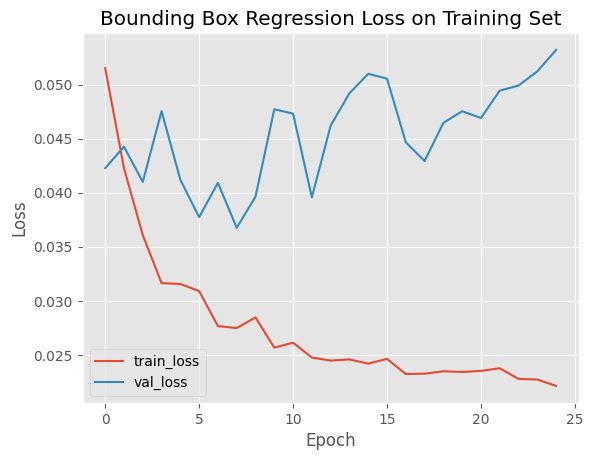

In [20]:
N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)


In [21]:
model = load_model(MODEL_PATH)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


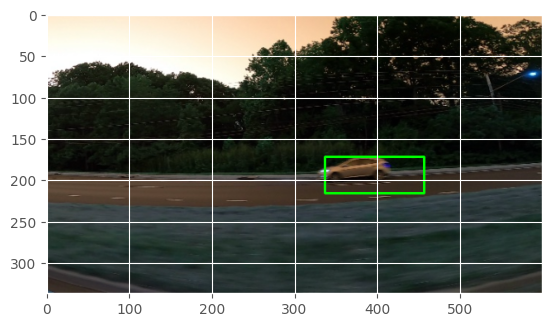

In [22]:
imagePath = "/Datasets/testing_images/vid_5_29460.jpg"

image = load_img(imagePath, target_size=(224, 224))
image = img_to_array(image) / 255.0
image = np.expand_dims(image, axis=0)

preds = model.predict(image)[0]

(startX, startY, endX, endY) = preds

image = cv2.imread(imagePath)
image = imutils.resize(image, width=600)
(h, w) = image.shape[:2]

startX = int(startX * w)
startY = int(startY * h)
endX = int(endX * w)
endY = int(endY * h)

cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)

plt.imshow(image)


# **Mobilenet SSD Model**

In [1]:
import os
base_path="Datasets/train_img"
images=os.path.sep.join([base_path,'images'])
annotations=os.path.sep.join([base_path,'train_label'])

In [2]:
rows= open(annotations).read().strip().split("\n")

data=[]
targets=[]
filenames=[]

In [3]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
base_model = MobileNetV2(input_shape=(300, 300, 3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

C:\Users\rithi\AppData\Local\Temp\ipykernel_26908\3163434304.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(300, 300, 3), include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [4]:
model.compile(loss='mse',optimizer=opt)

In [5]:
model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [6]:
history = model.fit(train_images,train_targets,validation_data=(test_images,test_targets),batch_size=32,epochs=50,verbose=1)

Epoch 1/50
23/23 [==============================] - 4s 155ms/step - loss: 0.0342 - val_loss: 0.0186
Epoch 2/50
23/23 [==============================] - 3s 152ms/step - loss: 0.0124 - val_loss: 0.0080
Epoch 3/50
23/23 [==============================] - 4s 153ms/step - loss: 0.0072 - val_loss: 0.0069
Epoch 4/50
23/23 [==============================] - 4s 155ms/step - loss: 0.0061 - val_loss: 0.0066
Epoch 5/50
23/23 [==============================] - 4s 155ms/step - loss: 0.0057 - val_loss: 0.0064
Epoch 6/50
23/23 [==============================] - 3s 151ms/step - loss: 0.0042 - val_loss: 0.0026
Epoch 7/50
23/23 [==============================] - 3s 148ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 8/50
23/23 [==============================] - 3s 147ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 9/50
23/23 [==============================] - 3s 146ms/step - loss: 7.5519e-04 - val_loss: 0.0020
Epoch 10/50
23/23 [==============================] - 3s 142ms/step - loss: 6.2409e-04 - val_loss

In [7]:
import cv2
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
for row in rows:
  row=row.split(",")
  (filename,startX,startY,endX,endY)=row

  imagepaths=os.path.sep.join([images,filename])
  image=cv2.imread(imagepaths)
  (h,w)=image.shape[:2]

  startX = float(startX) / w
  startY = float(startY) / h 
  endX = float(endX) / w
  endY = float(endY) / h
  image=load_img(imagepaths,target_size=(224,224))
  image=img_to_array(image)

  targets.append((startX,startY,endX,endY))
  filenames.append(filename)
  data.append(image)


In [8]:
preds=model.predict(image)[0]
(startX,startY,endX,endY)=preds

In [9]:
import imutils

In [10]:
image=cv2.imread(imagepaths)
image=imutils.resize(image,width=600)

In [11]:
(h,w)=image.shape[:2]

In [12]:
startX=int(startX * w)
startY=int(startY * h)

endX=int(endX * w)
endY=int(endY * h)

In [13]:
cv2.rectangle(image,(startX,startY),(endX,endY),(0,255,0),3)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

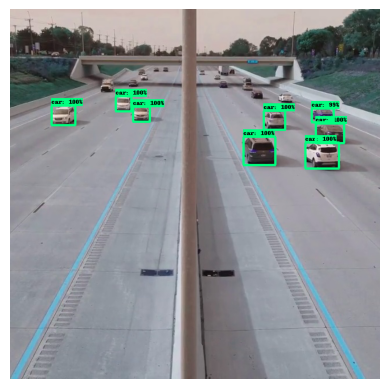

In [14]:
# import the necessary packages
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

CLASSES = ["background", "aeroplane", "bicycle", "bird", "boat",
	"bottle", "bus", "car", "cat", "chair", "cow", "diningtable",
	"dog", "horse", "motorbike", "person", "pottedplant", "sheep",
	"sofa", "train", "tvmonitor"]
COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

model = 'MobileNetSSD_deploy.caffemodel'
ptxt = 'MobileNetSSD_deploy.prototxt.txt'
net = cv2.dnn.readNetFromCaffe(ptxt, model)

images_dir = '/Datasets/train_img'
images = [os.path.join(images_dir, file) for file in os.listdir(images_dir)]

for img_path in images[:500]:
    image = cv2.imread(img_path)
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 0.007843, (300, 300), 127.5)

    net.setInput(blob)
    detections = net.forward()

    car_detected = False
    for i in np.arange(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        # greater than the minimum confidence
        if confidence > 0.3:
            idx = int(detections[0, 0, i, 1])
            if CLASSES[idx] == 'car':  # Check if the detected object is a car
                dog_detected = True
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (startX, startY, endX, endY) = box.astype("int")

                # display the prediction
                label = "{}: {:.2f}%".format(CLASSES[idx], confidence * 100)
                cv2.rectangle(image, (startX, startY), (endX, endY),
                    COLORS[idx], 2)
                y = startY - 15 if startY - 15 > 15 else startY + 15
                cv2.putText(image, label, (startX, y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLORS[idx], 2)
                
    # plot the output image using matplotlib if a dog is detected
    if car_detected:
        plt.figure()
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
        break


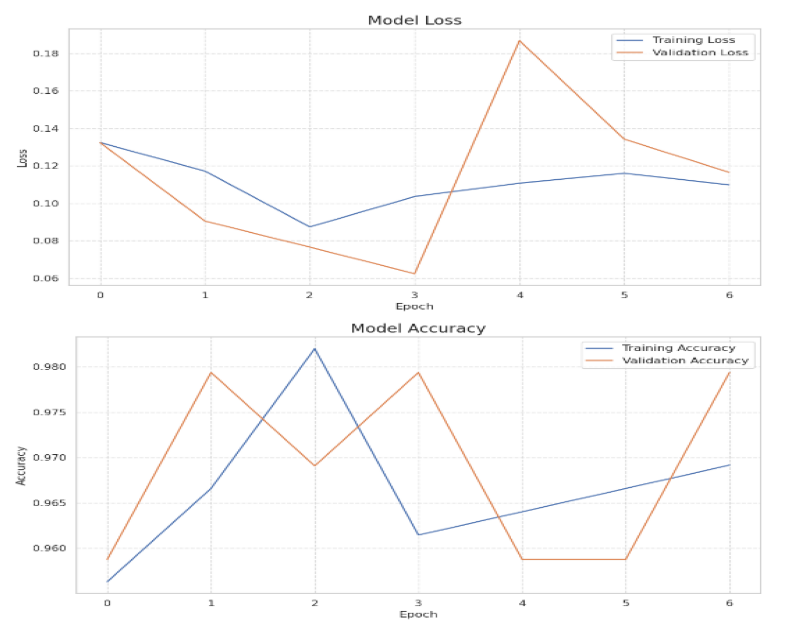

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label='Training Loss') 
plt.plot(epochs, val_loss, 'orange', label='Validation Loss') 
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy') 
plt.plot(epochs, val_acc, 'orange', label='Validation Accuracy') 
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.show()
